In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [25]:
from typing import List
from collections import OrderedDict
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# sns.set_context("notebook")
# sns.set_theme("whitegrid")

In [26]:
class Segmentations:
    def __init__(self,
                 path_to_seg_file: str,
                 song_names: List[str]):
        segment_mappings, self.segments, _ = \
            np.load(path_to_seg_file, allow_pickle=True)
        self.song_names = [name.upper() for name in song_names]
        self.segment_mappings = OrderedDict((v, k) for k, v in segment_mappings.items())
        
    def initialize_genre_information(self, song_df):
        self.segment_to_genre = {}
        for _, song in song_df.iterrows():
            genre = song["Genre"]
            try:
                song_range = self.get_song_name_range(song["Artist - Title"])
            except ValueError:
                continue
            self.segment_to_genre.update(
                {k: genre for k in song_range}
            )
    
    def get_song_name_range(self, name):
        song_idx = self.song_names.index(name)
        segment_idx = self.segment_mappings[song_idx]
        return list(range(segment_idx, segment_idx + len(self.segments[song_idx])))

In [27]:
musdb_root = "/exports/projects/computer-audition/data/musdb/raw/stems/"
train_songs = sorted([p.rsplit(".", 2)[0] for p in os.listdir(os.path.join(musdb_root, "train"))])
train_segmentations = Segmentations("train_segmentation.npy", train_songs)
test_songs = sorted([p.rsplit(".", 2)[0] for p in os.listdir(os.path.join(musdb_root, "test"))])
test_segmentations = Segmentations("test_segmentation.npy", test_songs)

test_data = {}
test_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented/aggreggate.csv")
test_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented/aggreggate.csv")
test_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented/aggreggate.csv")
test_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented/aggreggate.csv")
         
train_data = {}
train_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented_train/aggreggate.csv")
train_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented_train/aggreggate.csv")
train_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented_train/aggreggate.csv")
train_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented_train/aggreggate.csv")

genre_metadata = pd.concat([
    pd.read_csv("medleydb_genre.csv"), pd.read_csv("dsd_genre.csv", quotechar='"'), pd.read_csv("self_labeled.csv")
],axis=0).reset_index()[["Artist - Title", "Genre"]]
genre_metadata["Artist - Title"] = genre_metadata["Artist - Title"].apply(lambda name: name.replace(" Multitracks", "").upper())
genre_metadata["Split"] = genre_metadata["Artist - Title"].apply(
    lambda name: 'train' if name in train_segmentations.song_names
                         else ('test' if name in test_segmentations.song_names
                                      else None)
)
# Combining pop and rock together, because DSD combines them
genre_metadata["Genre"] = genre_metadata["Genre"].apply(lambda name: "Pop/Rock" if name in ["Pop", "Rock"] else name)
genre_metadata_valid = genre_metadata[(genre_metadata["Split"] == 'test') | (genre_metadata["Split"] == 'train')]

In [28]:
genres = genre_metadata_valid["Genre"].value_counts()
test_segmentations.initialize_genre_information(genre_metadata_valid)
train_segmentations.initialize_genre_information(genre_metadata_valid)
display(genres)

Pop/Rock             97
Singer/Songwriter    16
Heavy Metal          12
Electronic            9
Rap                   8
Jazz                  3
Reggae                2
Musical Theatre       2
Country               1
Name: Genre, dtype: int64

In [29]:
def split_by_sources(df):
    return {name: g_df for name, g_df in df.groupby(by="source")}

def split_by_genre(song_df, data_dict, split):
    """
    song_df: pandas.DataFrame
    data_dict: Dictionary of dictionaries, indexed by data_dict[model][sources]
    split: str, either "test" or "train"
    return: Dictionary of pandas.dfs, indexed by return[model][sources][genre]
    """
    assert split in ["test", "train"]
    segmentations = test_segmentations if split == "test" else train_segmentations
    separated_dict = {}
    for model, model_dict in data_dict.items():
        separated_dict[model] = {}
        for source, df in model_dict.items():
            df = df.copy()
            df["genre"] = df["file"].apply(
                lambda x: segmentations.segment_to_genre[int(x.split(".")[0])]
            )
            separated_dict[model][source] = {genre: g_df for genre, g_df in df.groupby(by="genre")}
    return separated_dict
            
#     return filtered_data
test_data_sources = {k: split_by_sources(df) for k, df in test_data.items()}
train_data_sources = {k: split_by_sources(df) for k, df in train_data.items()}
test_data_split = split_by_genre(genre_metadata_valid, test_data_sources, "test")
train_data_split = split_by_genre(genre_metadata_valid, train_data_sources, "train")

In [56]:
def plot_si_sdri(dictionary, metric="SI-SDRi", ylim=None, figsize=(10, 8)):
    """
     source_data: DataFrames organized in dictionaries
         indexed by source_data[key1][key2]
     The source_data will be displayed in rows indexed by key1, then in columns by key2
     Rows will share a y-axis
         
     ylim: Tuple of length two, minimum and max of data that should be shown.
         
    """
    first_keys = list(dictionary.keys())
    rows = len(first_keys)
    columns = len(dictionary[first_keys[0]])
    fig, axes = plt.subplots(rows, columns, sharey="row", figsize=figsize)
    for i, (first_key, i_dict) in enumerate(dictionary.items()):
        for j, (second_key, df) in enumerate(i_dict.items()):
            ax = axes[i][j]
            ax.grid(axis="y")
            if ylim is not None:
                ax.set_ylim(*ylim)
            sns.violinplot(y=metric, data=df, ax=ax)
            if i == 0:
                ax.set_title(second_key)

            if j == 0:
                ax.set_ylabel(first_key)
            else:
                ax.set_ylabel("")
            
    display(fig)

## Comparing models by Genre
We will look at all sources, however, only one source will appear when you are looking at this on github.
Note that there is no musical theatre nor country in the test set.

#### My observations:
Vocals:
 + In each test genre, conv-tasnet has roughly equal or better performance than demucs, except for electronic, where demucs beats conv-tasnet.
 + OpenUnmix does surprisingly well on the electronic test set, compared to its performance on other genres compared to Demucs and Conv-Tasnet.
 + Demucs beats Conv-Tasnet on every genre in the training set, except for jazz. Does this imply that Demucs is overfitting to the training set?
 
Drums:
 + Conv-Tasnet's performance on reggae test set is far better than any other model. Additionally, the distribution for the SI-SDRi of all model's performance on reggae is bimodal. 
 + Generally, the order of performance on the test and training sets follows from the rankings found in other notebooks.
 
Bass: 
 + Demucs seems to be the strongest on bass, especially on the electronic test set.
 
Other:
 + Generally lower SI-SDRis.
 
Overall:
 + Reggae bass, reggae other, reggae drums, and Electronic vocals seems to be the hardest genres + source pairs. 


Using matplotlib backend: agg
Using matplotlib backend: agg


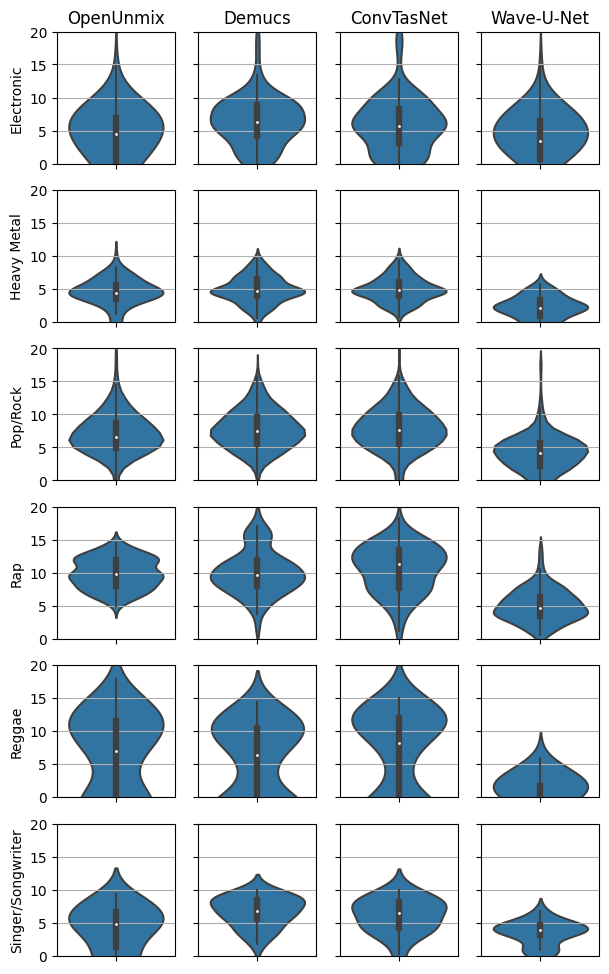

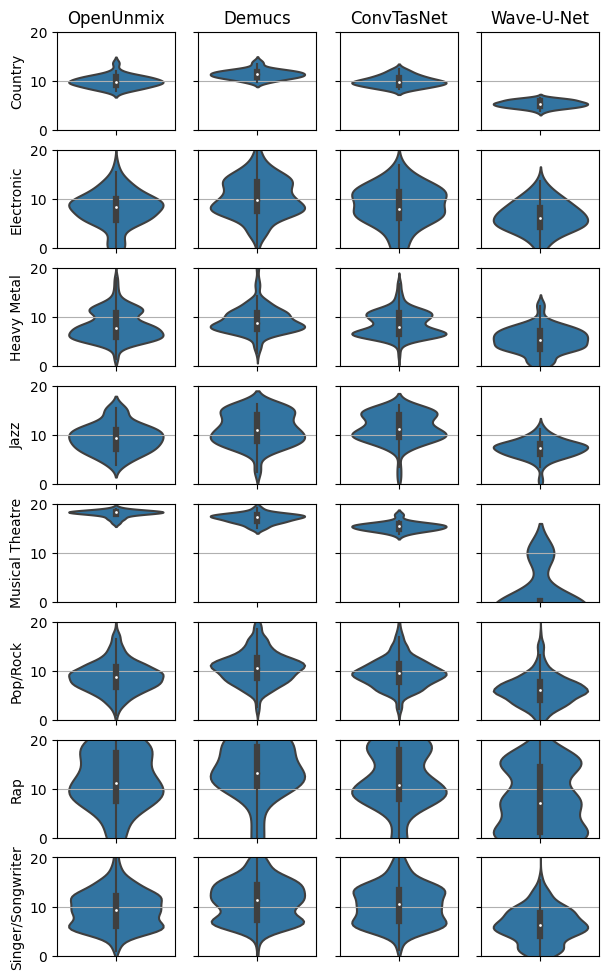

In [63]:
%matplotlib
%matplotlib
source = 'other'
def format_dict(d):
    models = d.keys()
    genres = d[list(models)[0]][source].keys()
    input_dict = {g: {} for g in genres}
    for model in models:
        for genre in genres:
            input_dict[genre][model] = d[model][source][genre]
    return input_dict
display(HTML("<strong>Test</strong><br/>"))
plot_si_sdri(format_dict(test_data_split), figsize=(7, 12), ylim=(0, 20))
display(HTML("<strong>Train</strong><br/>"))
plot_si_sdri(format_dict(train_data_split), figsize=(7, 12), ylim=(0, 20))

# The following graphs are best for comparing genres between sources for given models.

## Test

Using matplotlib backend: agg
Using matplotlib backend: agg


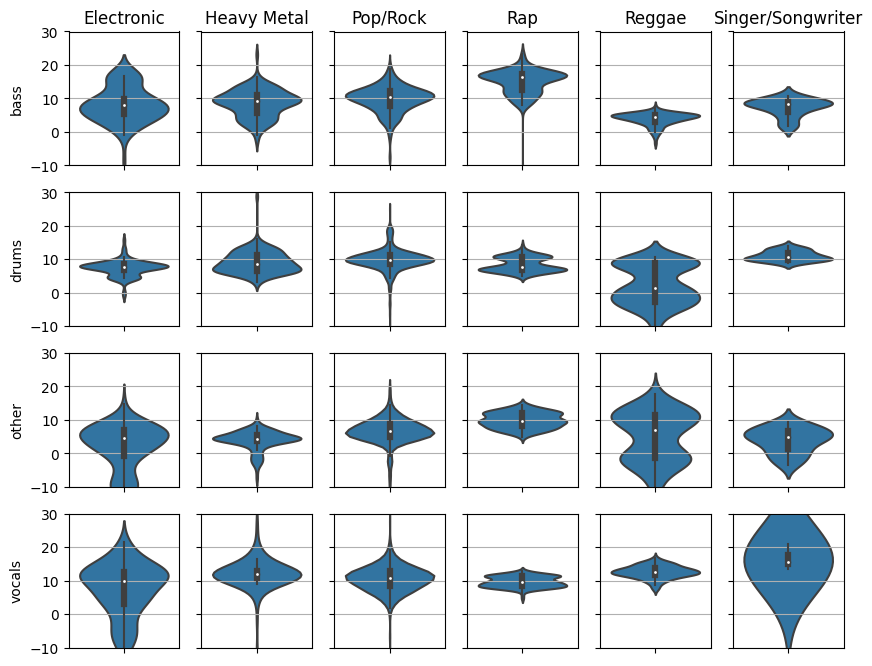

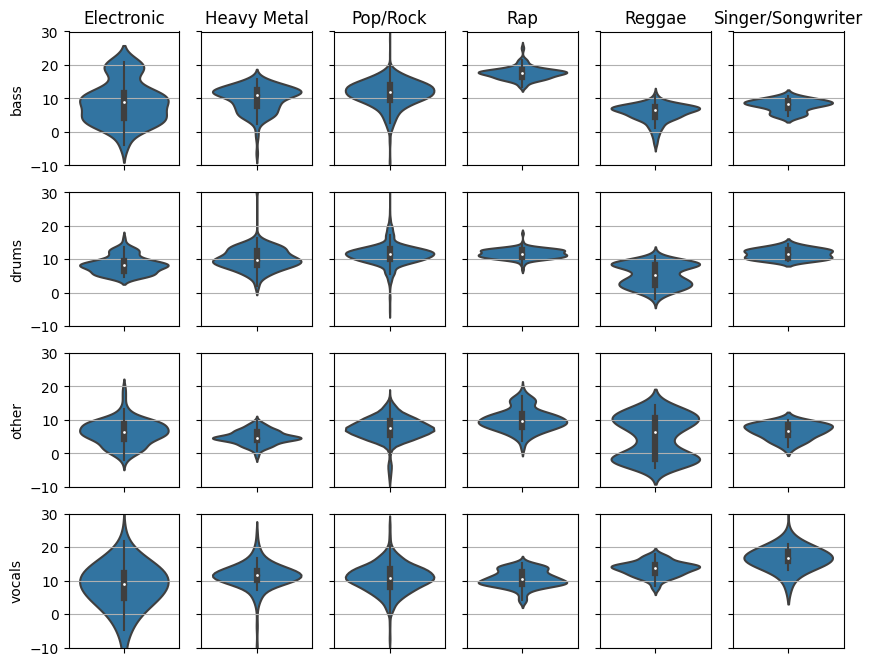

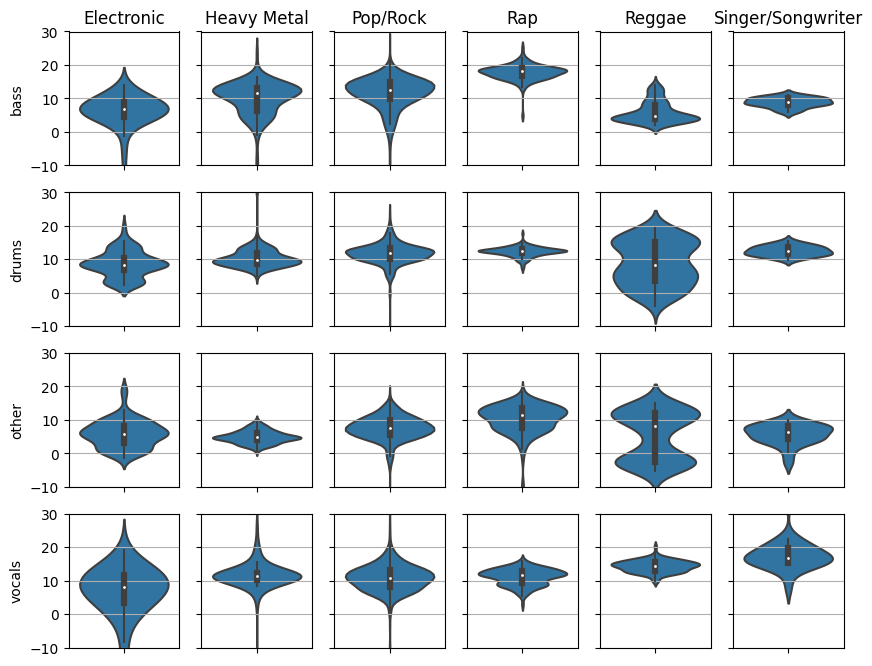

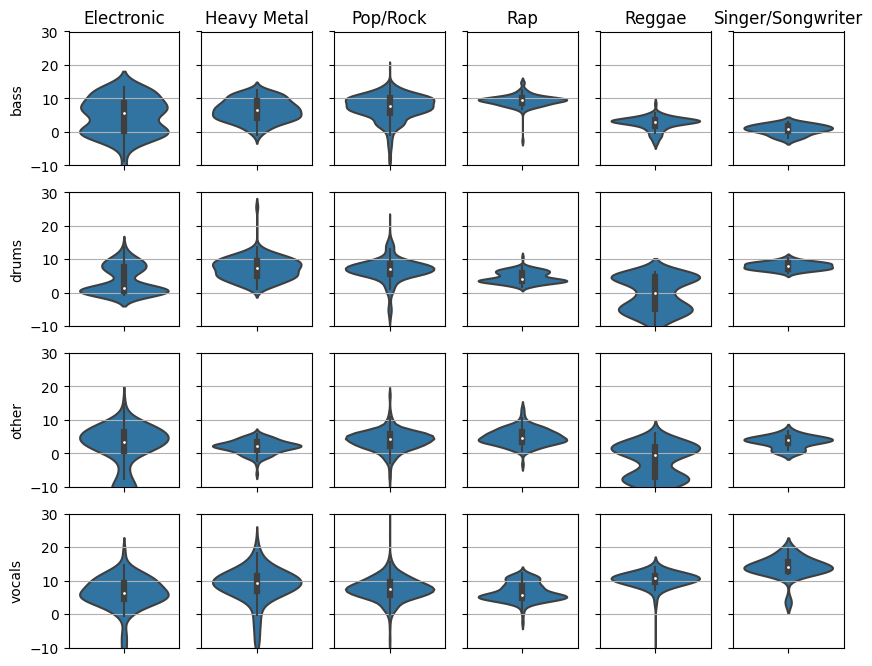

In [54]:
%matplotlib
%matplotlib
for model_name, sources_data in test_data_split.items():
    display(HTML(f"<strong>{model_name}</strong><br/>"))
    plot_si_sdri(sources_data, ylim=(-10, 30))
prevent_extra_prints = 0

# Train

Using matplotlib backend: agg
Using matplotlib backend: agg


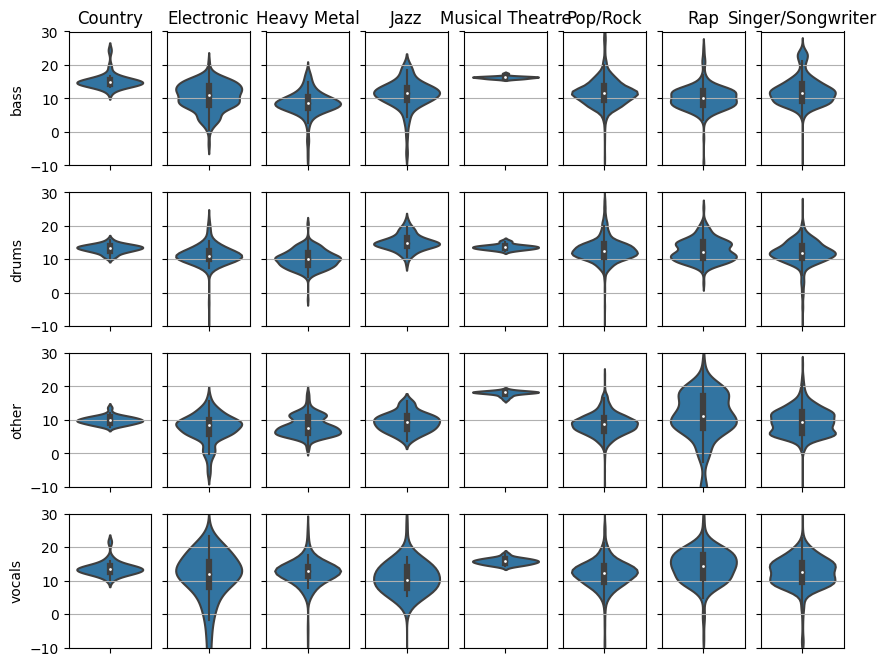

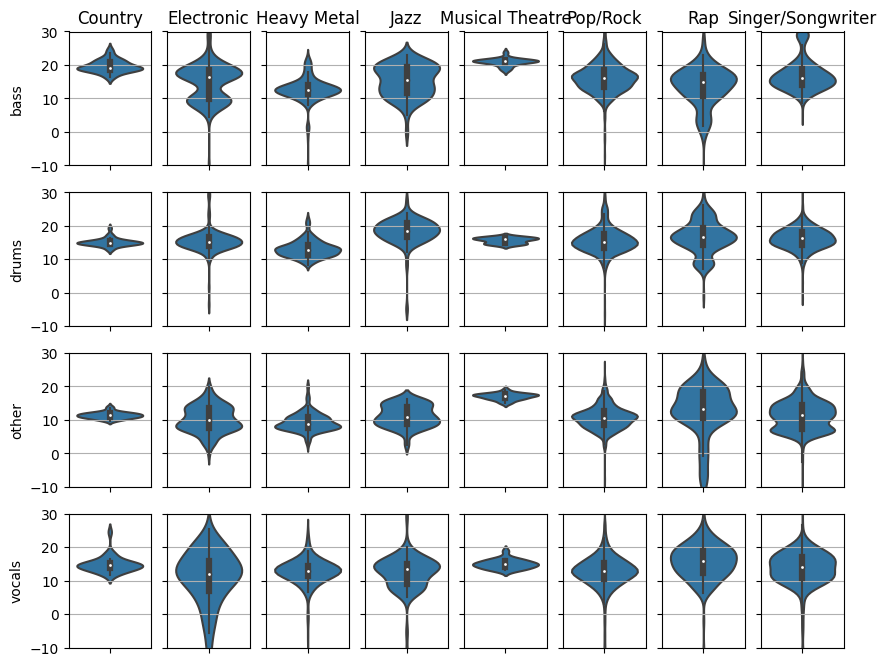

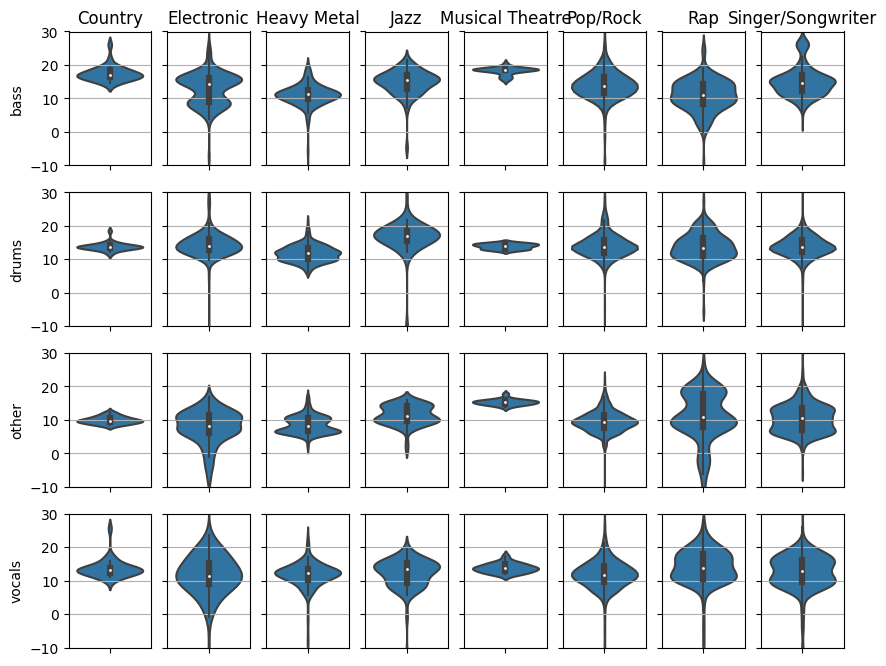

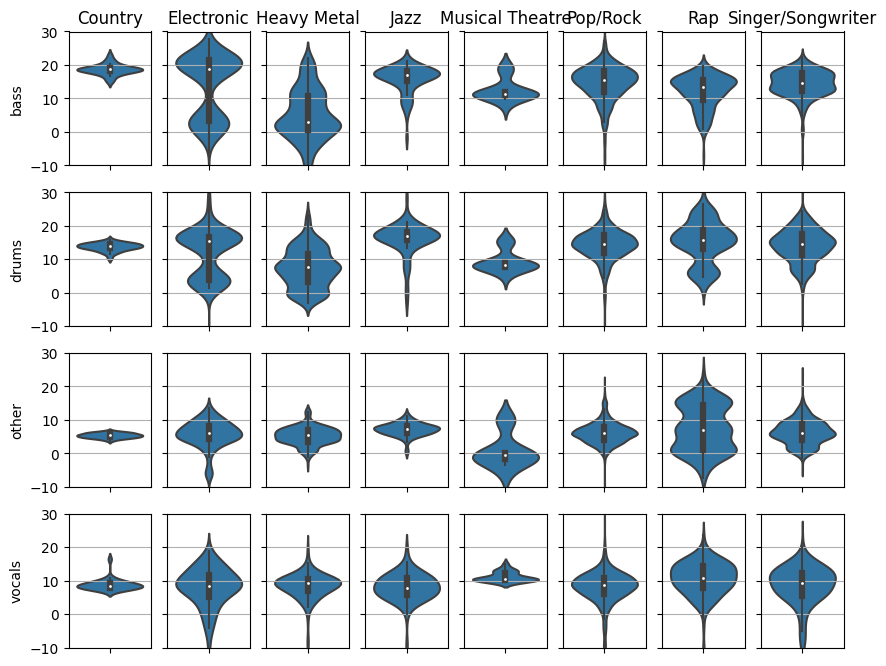

In [40]:
%matplotlib
%matplotlib
for model_name, sources_data in train_data_split.items():
    display(HTML(f"<strong>{model_name}</strong><br/>"))
    plot_si_sdri(sources_data, ylim=(-10, 30))